# Antibiotic resistance prediction

## Project Introduction
This project aims to predict antibiotic resistance using structured electronic health record (EHR) data from the Antibiotic Resistance Microbiology Dataset (ARMD). The goal is to classify whether a bacterial isolate is susceptible (S) or resistant (R) to a given antibiotic, based on clinical, demographic, microbiological, and treatment-related features. This binary classification model supports empirical antibiotic selection and contributes to combating antimicrobial resistance in clinical settings.

In [3]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

final_armd_ds = 'ARMD_Dataset/selected_features_output.parquet'

df = pd.read_parquet(final_armd_ds)
print(df.shape)


(2184195, 26)


## Drop nulls

In [5]:
df = df.dropna()
print(df.shape)

(2124287, 26)


### Separate target + binary encoding

In [7]:
target_col = 'susceptibility_label'
df[target_col] = df[target_col].map({'S': 0, 'R': 1})  
y = df[target_col]
X = df.drop(columns=[target_col])
print('y: ',y.shape)
print('X: ',X.shape)

y:  (2124287,)
X:  (2124287, 25)


### Identify column types

In [9]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2124287 entries, 22 to 2183663
Data columns (total 25 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   organism_x                      string 
 1   antibiotic_x                    string 
 2   resistant_time_to_culturetime   float64
 3   age                             string 
 4   gender                          string 
 5   adi_score                       string 
 6   adi_state_rank                  string 
 7   median_wbc                      string 
 8   median_neutrophils              string 
 9   median_lymphocytes              string 
 10  median_hgb                      string 
 11  median_plt                      string 
 12  median_na                       string 
 13  median_hco3                     string 
 14  median_bun                      string 
 15  median_cr                       string 
 16  median_lactate                  string 
 17  median_procalcitonin           

In [10]:
categorical_cols = X.select_dtypes(include=['string']).columns
numeric_cols = X.select_dtypes(include=['number']).columns
print(f'categorical_cols: {categorical_cols}')
print('--------------------------------------------')
print(f'numeric_cols: {numeric_cols}')

categorical_cols: Index(['organism_x', 'antibiotic_x', 'age', 'gender', 'adi_score',
       'adi_state_rank', 'median_wbc', 'median_neutrophils',
       'median_lymphocytes', 'median_hgb', 'median_plt', 'median_na',
       'median_hco3', 'median_bun', 'median_cr', 'median_lactate',
       'median_procalcitonin', 'medication_category'],
      dtype='object')
--------------------------------------------
numeric_cols: Index(['resistant_time_to_culturetime', 'median_heartrate', 'median_resprate',
       'median_temp', 'median_sysbp', 'median_diasbp',
       'medication_time_to_culturetime'],
      dtype='object')


### Encode categorical columns

In [12]:
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le  # Save encoder if needed later


### Verify All Columns Are Numeric

In [14]:
non_numeric_cols = X.select_dtypes(exclude=["number"]).columns
print("Non-numeric columns:", non_numeric_cols.tolist())


Non-numeric columns: []


### Fill missing values (numeric only here, since all is numeric now)

In [16]:
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)


### Combine imputed features with target

In [18]:
df_numeric = X_imputed.copy()
df_numeric['susceptibility_label'] = y.values


### Save as Parquet

In [20]:
df_numeric.to_parquet("numeric_dataset.parquet", index=False)
print("✅ All features numeric and saved to 'numeric_dataset.parquet'")

✅ All features numeric and saved to 'numeric_dataset.parquet'


## Load the Data

In [22]:
import pandas as pd

df = pd.read_parquet("numeric_dataset.parquet")
X = df.drop(columns=["susceptibility_label"])
y = df["susceptibility_label"]


## Train/Test Split + Scale

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [25]:
df = pd.DataFrame(X_train_scaled)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,0.204293,0.05337,0.044032,0.258137,0.306157,0.221815,0.300496,-0.323723,0.152723,-0.338935,...,0.273892,-0.130419,0.059845,-0.052204,0.275076,0.2787,-0.274561,-0.134028,0.380218,-0.492303
1,0.204293,0.05337,-0.003555,0.258137,0.306157,0.221815,0.300496,-0.323723,0.152723,-0.338935,...,0.273892,-0.130419,0.059845,-0.052204,0.275076,0.2787,-0.274561,-0.134028,-1.102251,-0.566275
2,0.204293,0.05337,0.662663,0.258137,0.306157,0.221815,0.300496,-0.323723,0.152723,-0.338935,...,0.273892,-0.130419,0.059845,-0.052204,0.275076,0.2787,-0.274561,-0.134028,0.973206,-0.500791
3,0.204293,0.05337,-0.379492,0.258137,0.306157,0.221815,0.300496,-0.323723,0.152723,-0.338935,...,0.273892,-0.130419,0.059845,-0.052204,0.275076,0.2787,-0.274561,-0.134028,0.380218,-0.489877
4,0.204293,0.05337,-0.379492,0.258137,0.306157,0.221815,0.300496,-0.323723,0.152723,-0.338935,...,0.273892,-0.130419,0.059845,-0.052204,0.275076,0.2787,-0.274561,-0.134028,-1.102251,-0.474113


## Models implementation

Optimized Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.74      0.06      0.11    239884
           1       0.44      0.97      0.61    184974

    accuracy                           0.46    424858
   macro avg       0.59      0.52      0.36    424858
weighted avg       0.61      0.46      0.33    424858


ROC AUC Score: 0.551

Confusion Matrix:
[[ 14107 225777]
 [  4977 179997]]


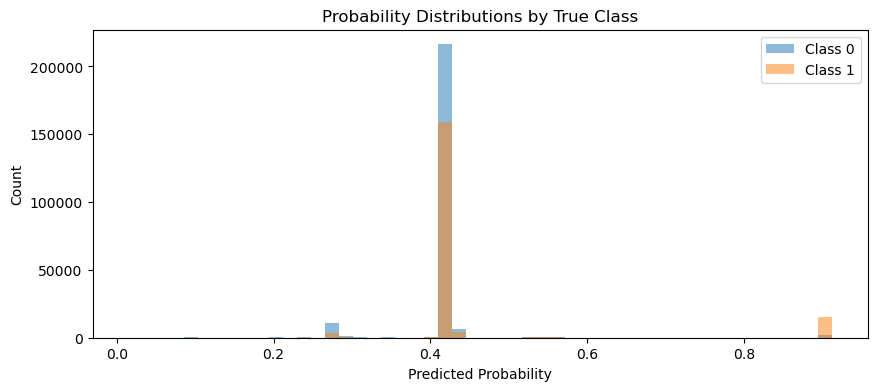

In [27]:
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd

# 1. Create the modeling pipeline
model = make_pipeline(
    RobustScaler(),  # Better for handling outliers
    LogisticRegression(
        max_iter=5000,
        class_weight='balanced',  # Automatic class balancing
        random_state=42,
        solver='saga',
        penalty='l2',
        C=0.1  # Stronger regularization
    )
)

# 2. Train with probability calibration
calibrated_model = CalibratedClassifierCV(model, cv=3)
calibrated_model.fit(X_train_scaled, y_train)

# 3. Make predictions (with adjusted threshold)
y_prob = calibrated_model.predict_proba(X_test_scaled)[:,1]
y_pred_adj = (y_prob > 0.4).astype(int)  # Using 0.4 threshold instead of default 0.5

# 4. Evaluate performance
print("Optimized Logistic Regression Performance:")
print(classification_report(y_test, y_pred_adj))
print(f"\nROC AUC Score: {roc_auc_score(y_test, y_prob):.3f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_adj))

# 5. Visual inspection of probabilities
plt.figure(figsize=(10, 4))
plt.hist(y_prob[y_test==0], bins=50, alpha=0.5, label='Class 0')
plt.hist(y_prob[y_test==1], bins=50, alpha=0.5, label='Class 1')
plt.legend()
plt.title("Probability Distributions by True Class")
plt.xlabel("Predicted Probability")
plt.ylabel("Count")
plt.show()